# DAT565/DIT407 Assignment 5

Author: Group 26 | Wenjun Tian wenjunt@chalmers.se | Yifan Tang yifant@chalmers.se

Date: 2024-12-07

# Problem 1: Preprocessing the dataset

First, the dataset is processed by separating the features from the labels. The features are then normalized using the `StandardScaler()` from `sklearn.preprocessing`. The standardized features are converted into a new DataFrame for easier manipulation and analysis. Finally, the normalized features are combined with the labels, and the complete dataset is saved as a new `.csv` file, making it ready for further analysis.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

file_path = './seeds.tsv'
column_names = [
    "Area",
    "Perimeter",
    "Compactness",
    "Length of kernel",
    "Width of kernel",
    "Asymmetry coefficient",
    "Length of the kernel groove",
    "Numerical class label"
]

# read data
data = pd.read_table(file_path, header=None, names=column_names)
features = data.iloc[:, :-1]
labels = data.iloc[:, -1]

# normalize the dataset and convert normalized data to dataframe type.
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)
normalized_data = pd.DataFrame(normalized_features, columns=features.columns)

# combine normalized features with labels
normalized_data_with_labels = pd.concat([normalized_data, labels.reset_index(drop=True)], axis=1)
normalized_data_with_labels.columns = column_names

# print(normalized_data_with_labels.head())

# output the normalized data
normalized_data_with_labels.to_csv('normalized_seeds.csv', index=False)


# Problem 2: Determining the appropriate number of clusters

Based on the plot, k=3 is the optimal number of clusters for this dataset.
From k=1 to k=3, inertia decreases significantly, meaning the clustering process effectively reduces within-cluster variance. When k > 3, the decrease in inertia becomes smaller, indicating that adding more clusters does not significantly improve the clustering quality.

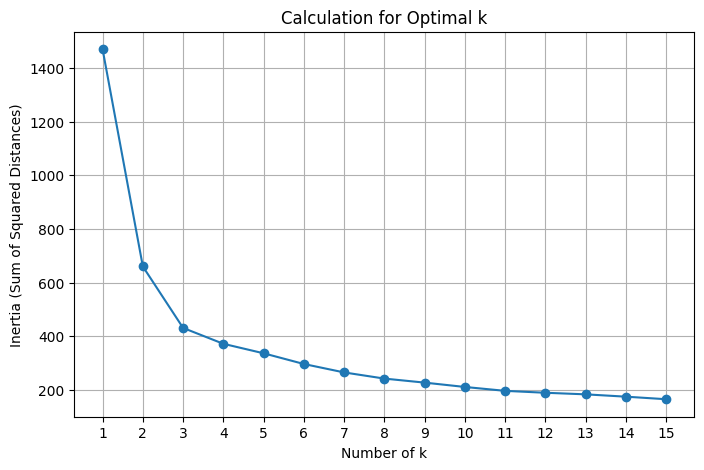

In [ ]:
from sklearn.cluster import KMeans

inertia_values = []
k_values = range(1, 16)  # test k from 1 to 15

# calculate inertia based on different k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertia_values.append(kmeans.inertia_)

# plot
plt.figure(figsize=(8, 5)) 
plt.plot(k_values, inertia_values, marker='o', linestyle='-')
plt.title('Calculation for Optimal k')
plt.xlabel('Number of k')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(k_values)
plt.grid()
plt.show()


# Problem 3: Visualizing the classes

## (a)
The scatter plot of Area vs. Perimeter is interesting. It shows that Area and Perimeter are strongly correlated features that contribute significantly to distinguishing the classes. It seems that wheat in Class 3 have larger area and perimeter, and that in Class 1 tend to have a smaller size.

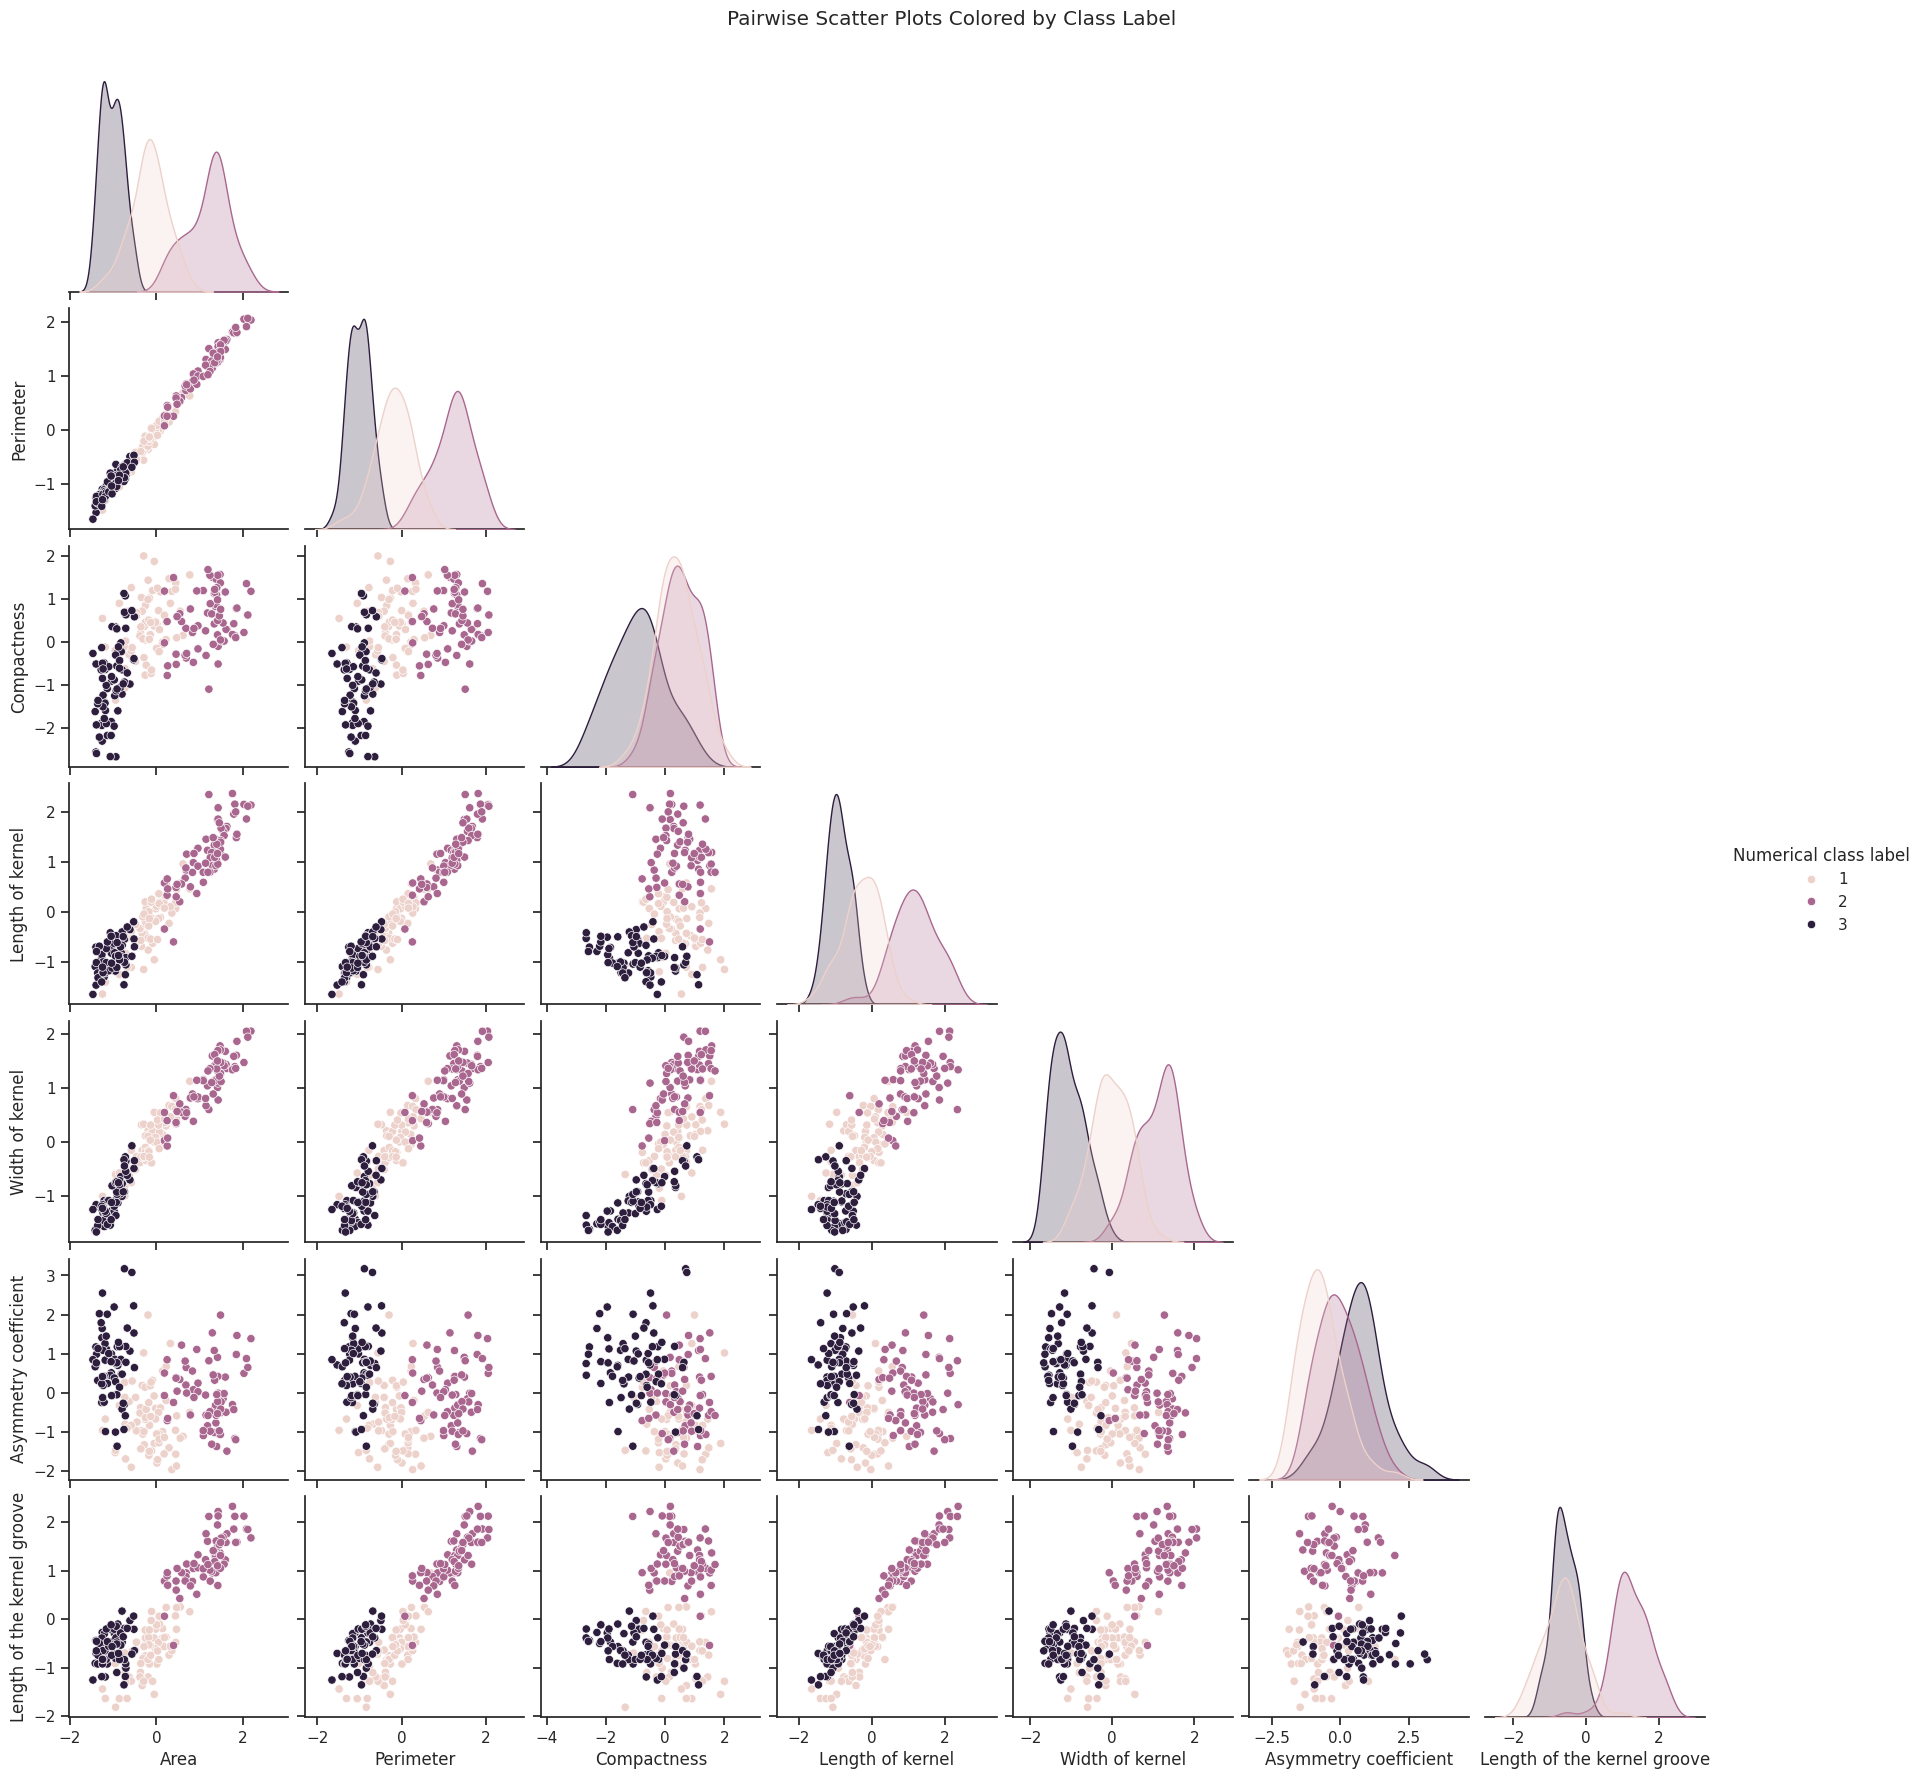

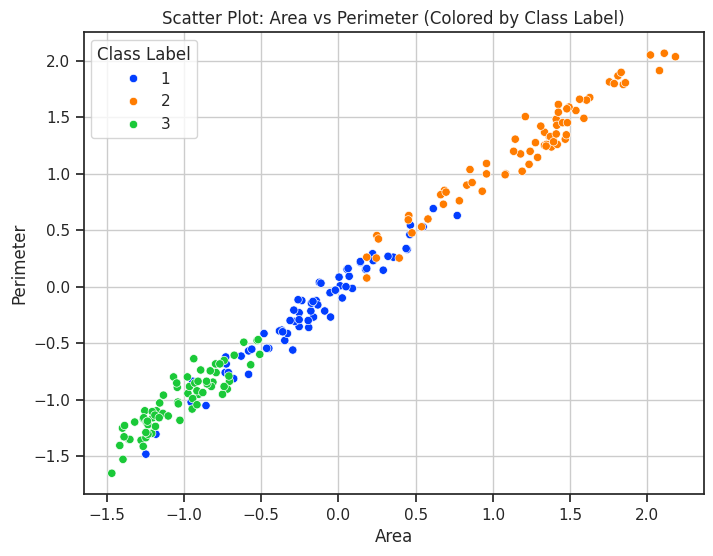

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# read the normalized data
file_path = 'normalized_seeds.csv'
data = pd.read_csv(file_path)

features = data.iloc[:, :-1]
labels = data["Numerical class label"]

sns.set_theme(style="ticks", palette="bright")
pairplot = sns.pairplot(data, hue="Numerical class label", corner=True)
pairplot.figure.suptitle("Pairwise Scatter Plots Colored by Class Label", y=1.02)
plt.show()

# select Area and Perimeter
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=data["Area"], y=data["Perimeter"], hue=data["Numerical class label"], palette="bright"
)
plt.title("Scatter Plot: Area vs Perimeter (Colored by Class Label)")
plt.xlabel("Area")
plt.ylabel("Perimeter")
plt.legend(title="Class Label")
plt.grid()
plt.show()

## (b)

Based on the plot, Class 3 appears to form a tighter, more distinguishable cluster compared to Classes 1 and 2. Class 1 and Class 2 show a few overlap, indicating that these two classes might share more similarities in their features compared to Class 3.

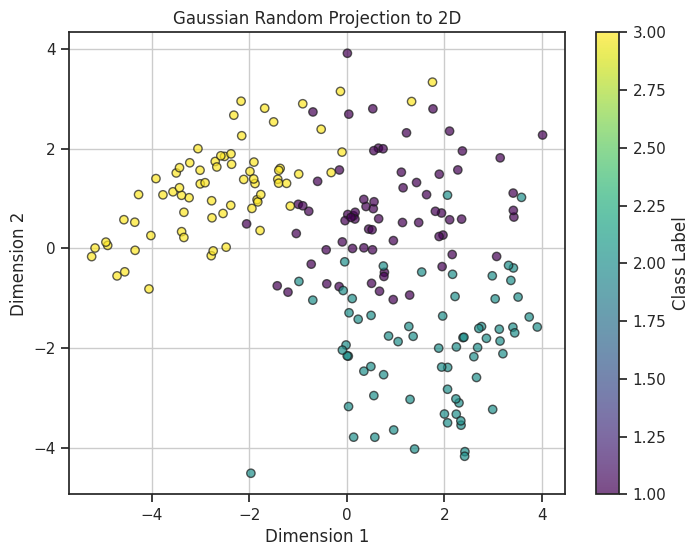

In [18]:
from sklearn.random_projection import GaussianRandomProjection

random_projection = GaussianRandomProjection(n_components=2)
projected_data = random_projection.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap="viridis", alpha=0.7, edgecolor="k")
plt.title("Gaussian Random Projection to 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label="Class Label")
plt.grid()
plt.show()


## (c)


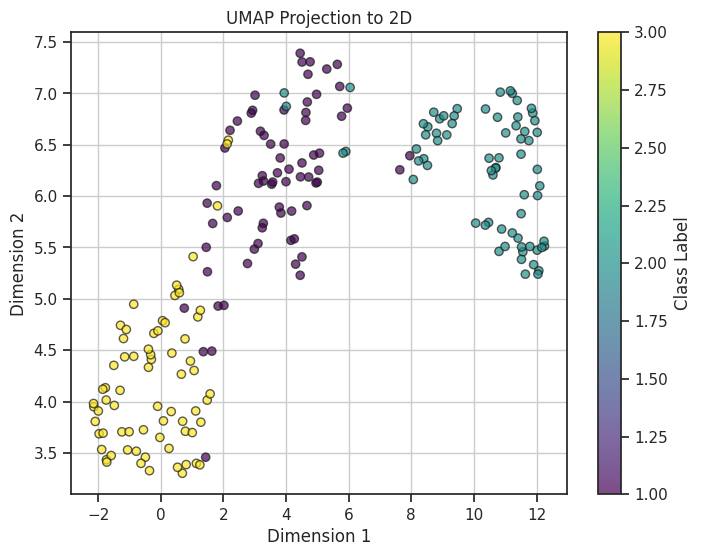

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, n_jobs=-1)
umap_projection = reducer.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_projection[:, 0], umap_projection[:, 1], c=labels, cmap="viridis", alpha=0.7, edgecolor="k")
plt.title("UMAP Projection to 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label="Class Label")
plt.grid()
plt.show()


## (d)
> does the data look linearly separable? Why / why not?

The data does not appear to be linearly separable in the higher-dimensional space or in non-linear projections like UMAP. However, specific feature combinations show that some linear separability exists for certain features.

> What implications does this have for clustering?

Since the data is not linearly separable, it's hard for simple linear methods such as K-Means to achieve good clustering. Overlap between clusters in projections like UMAP and Gaussian Random Projection indicates that more sophisticated, non-linear techniques might perform better. However, the Area vs Perimeter plot demonstrates that selecting the right features can greatly improve linear separability, which may simplify clustering.

# Problem 4: Evaluating clustering

In [20]:
import numpy as np
from sklearn.metrics import rand_score
from scipy.optimize import linear_sum_assignment

# get unique class labels
k = len(np.unique(labels))
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# calculate Rand Index
rand_index = rand_score(labels, cluster_labels)
print(f"Rand Index: {rand_index}")

def compute_accuracy(true_labels, cluster_labels, k):
    contingency_matrix = np.zeros((k, k), dtype=int)
    for true, cluster in zip(true_labels, cluster_labels):
        contingency_matrix[true - 1][cluster] += 1
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

    # calculate accuracy
    accuracy = contingency_matrix[row_ind, col_ind].sum() / len(true_labels)
    permutation = {cluster: true_label + 1 for cluster, true_label in enumerate(col_ind)}
    return accuracy, permutation

accuracy, permutation = compute_accuracy(labels, cluster_labels, k)
print(f"Accuracy: {accuracy}")
formatted_permutation = "\n".join([f"Cluster {cluster} → Class {true_label}" for cluster, true_label in permutation.items()])
print("Cluster to Class Mapping:")
print(formatted_permutation)


Rand Index: 0.9102756892230577
Accuracy: 0.9285714285714286
Cluster to Class Mapping:
Cluster 0 → Class 3
Cluster 1 → Class 1
Cluster 2 → Class 2


# Problem 5: Agglomerative clustering

> Which works best and which worst, in terms of accuracy at the assumed correct number of clusters? 

The Ward linkage performs best with an accuracy of 0.9286, and the Single linkage performs the worst with an accuracy of 0.3476.

> Why do you think this is the case?

Ward linkage minimizes the variance within clusters at each step. The clustering by Ward linkage aligns closely with the natural structure of the data, leading to the highest accuracy.
Single linkage defines cluster distance as the minimum distance between points in two clusters. This often results in "chaining", where points that are loosely connected get grouped into the same cluster, even if they belong to different natural clusters. As a result, the clusters formed by single linkage may not align well with the true structure, leading to the lowest accuracy.

Linkage Method: single, Accuracy: 0.3476190476190476
Linkage Method: complete, Accuracy: 0.8761904761904762
Linkage Method: average, Accuracy: 0.8809523809523809
Linkage Method: ward, Accuracy: 0.9285714285714286
Linkage Method: centroid, Accuracy: 0.6428571428571429
Linkage Method: weighted, Accuracy: 0.7952380952380952
Linkage Method: median, Accuracy: 0.6571428571428571
Best Linkage: ward, Accuracy: 0.9285714285714286
Worst Linkage: single, Accuracy: 0.3476190476190476


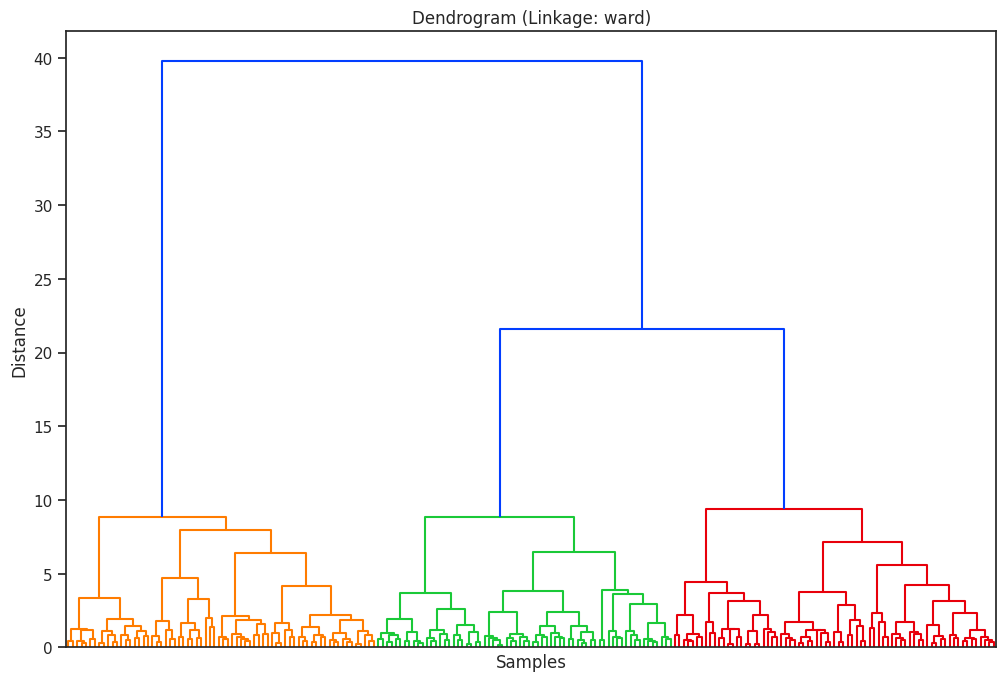

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# perform Agglomerative Clustering with Different Linkage Methods
linkage_methods = ['single', 'complete', 'average', 'ward', 'centroid', 'weighted', 'median']
accuracies = {}

for method in linkage_methods:
    if method in ['centroid', 'weighted', 'median']:
        # Use scipy linkage for centroid, weighted, and median
        try:
            linkage_matrix = linkage(features, method=method)
            from scipy.cluster.hierarchy import fcluster
            cluster_labels = fcluster(linkage_matrix, t=len(np.unique(labels)), criterion='maxclust') - 1
        except Exception as e:
            print(f"Method {method} is not supported by AgglomerativeClustering: {e}")
            continue
    else:
        # Use sklearn AgglomerativeClustering for other methods
        clustering = AgglomerativeClustering(n_clusters=len(np.unique(labels)), linkage=method)
        cluster_labels = clustering.fit_predict(features)

    accuracy, _ = compute_accuracy(labels, cluster_labels, len(np.unique(labels)))
    accuracies[method] = accuracy
    print(f"Linkage Method: {method}, Accuracy: {accuracy}")

# find the best and worst linkage method
best_method = max(accuracies, key=accuracies.get)
worst_method = min(accuracies, key=accuracies.get)
print(f"Best Linkage: {best_method}, Accuracy: {accuracies[best_method]}")
print(f"Worst Linkage: {worst_method}, Accuracy: {accuracies[worst_method]}")


linkage_matrix = linkage(features, method=best_method)
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=[f"Class {label}" for label in labels], leaf_rotation=90, leaf_font_size=10, color_threshold=15)
plt.title(f"Dendrogram (Linkage: {best_method})")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.xticks([])
plt.show()
